# Optimum binding energies for multi-electron transfer electrocatalyis
$$\require{mhchem}$$
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Adapts analyses in 
>(1) Ooka, H.; Nakamura, R. Shift of the Optimum Binding Energy at Higher Rates of Catalysis. [*J. Phys. Chem. Lett.* **2019**, 6706–6713](https://pubs.acs.org/doi/10.1021/acs.jpclett.9b01796).

Ooka and Nakamura consider the two steps of hydrogen oxidation reaction, Heyrovsky and Volmer, respectively:  
$$\ce{H2{(aq)} + $*$  <-> H_{ads} + H+ + e-}\tag{1}$$

$$\ce{H_{ads}   <-> $*$ + H+ + e-}\tag{2}$$

Note that Tafel step in not considered in the model in the paper (although it could be included). Also note that Tafel step is a chemical, not an electrochemical, step.    
$$  \ce{H2{(aq)} +  2$*$  <-> 2 H_{ads} }  $$

There are two equations for the surface species and a conservation condition (note that Eq. (3) has a misprint in the paper):
$$ \frac{d [\ce{H_{ads}}]}{dt} =  k_{1}[\ce{H2}][\ce{$*$}] + k_{-2}[\ce{H+}][\ce{$*$}] -  k_{-1}[\ce{H+}][\ce{H_{ads}}] - k_{2}[\ce{H_{ads}}] \tag{3} $$

$$ \frac{d [\ce{$*$}]}{dt} =  k_{-1}[\ce{H+}][\ce{H_{ads}}] + k_{2}[\ce{H_{ads}}] - k_{1}[\ce{H2}][\ce{$*$}] - k_{-2}[\ce{H+}][\ce{$*$}] $$

In steady state, both time derivatives will be zero. In this case, the \*H and \* concentrations are:

$$ [\ce{H_{ads}}] = [\ce{$*$}] \frac{ k_{1}[\ce{H2}] + k_{-2}[\ce{H+}]}{ k_{-1}[\ce{H+}] + k_{2} } $$

$$ [\ce{$*$}] = [\ce{H_{ads}}] \frac{ k_{-1}[\ce{H+}] + k_{2}}{ k_{1}[\ce{H2}] + k_{-2} [\ce{H+}]} $$

The addition of the surface conservation condition $[\ce{H_{ads}}]+[\ce{$*$}]=1 $ leads to the solutions:  
$$[\ce{H_{ads}}] = \frac{k_{1}[\ce{H2}] + k_{-2}[\ce{H+}]}{k_{1}[\ce{H2}] +k_{2} + (k_{-1}+k_{-2}) [\ce{H+}]} \tag{5} $$

$$[\ce{$*$}] =\frac{k_{-1}[\ce{H+}] + k_{2}}{k_{1}[\ce{H2}] +k_{2} + (k_{-1}+k_{-2}) [\ce{H+}]} $$

The reaction rate for H<sub>2</sub> is the overall rate of reaction (1). The current is *n* times this, where *n* is the number of electrons transferred per H<sub>2</sub>, which is 2.  

$$ j = nFN (k_{1}[\ce{H2}][\ce{$*$}] - k_{-1}[\ce{H+}][\ce{H_{ads}}]) \tag{6}$$

Combining equations (5) and (6) yield the current as a function of the rate constants.  

$$ j = nFN \frac{k_1 k_2 [\ce{H2}] - k_{-1} k_{-2}[\ce{H+}]^2}{k_{1}[\ce{H2}] +k_{2} + (k_{-1}+k_{-2}) [\ce{H+}]}\tag{7}$$


# Initialize

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp    # Changed from odeint, which will be deprecated eventually

In [2]:
# SI Base Units
meter, sec, mol, coul, volt, kelvin, kg = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [3]:
## Derived units and physical constants
amp    = coul*sec**-1 
joule  = kg * meter**2 * sec**-2

cm     = 1e-2*meter

mC     = 1e-3*coul
mA     = 10**-3*amp 
μA     = 10**-6*amp
nA     = 1e-9*amp
pA     = 1e-12*amp

mV     = 1e-3*volt

liter  = 1000*cm**3 
molar  = mol/liter 
mM     = 10**-3*molar 

## Physical constants
R      = 8.3144598                # in SI units, J mol-1 K-1
q      = 1.60217662*10**-19*coul  # Elementary charge
NA     = 6.02214076*10**23        # Avogadro number
F      = NA*q                     # Faraday constant

## Other units
eV     = 1.602176634*1e-19*joule
meV    = 1e-3*eV
kB     = R/NA

In [4]:
alpha = 0.5
T = 300 * kelvin

# Note scaling of the site density so it works out to be like the Faraday constant
Nsites = 0.5* 6.023* 10*1e15 * cm**-2              # active sites per geometric area
nTransfer = 2

f = (alpha * F)/(R * T)
print('value of f:', f)

print('nfN for Figure 1:', (nTransfer * q * Nsites)/(mC* cm**-2))

value of f: 19.340869922423245
nfN for Figure 1: 9.64990978226


In [5]:
Nsites/cm**-2

3.0115e+16

## Figure 1
HOR currents as a function of $E_1$, the binding energy of $\ce{H}$  
Calculation is done for different values of the potential (overpotential) *E*  
current will be zero if *E* = 0.  

definition of *f* allows use of eV for energy units. 

Base case:
> K = 1, k<sub>1</sub> = k<sub>1</sub> = 1 s<sup>-1</sup>   

To have Reaction (1) in equilibrium: 
>K = 10<sup>8</sup>, k<sub>1</sub> = 10<sup>4</sup> s<sup>-1</sup> and k<sub>2</sub> = 10<sup>-4</sup> s<sup>-1</sup>  

For have Reaction (2) in equilibrium
> K = 10<sup>-8</sup>, k<sub>1</sub> = 10<sup>-4</sup> s<sup>-1</sup> and k<sub>2</sub> = 10<sup>4</sup> s<sup>-1</sup>


In [6]:
def jEqn19(E, E1, K):
    k2zero = np.sqrt(1/K)   # For the normalization k1zero*k2zero = 1*sec^-2
    numerator = np.exp(2*f*E)-np.exp(-2*f*E)
    demoninator = K*np.exp(f*(E-E1)) + np.exp(f*(E+E1)) + \
                  K*np.exp(f*(E1-E)) + np.exp(-f*(E+E1))
    return (nTransfer * q * Nsites)* k2zero * K * (numerator / demoninator )

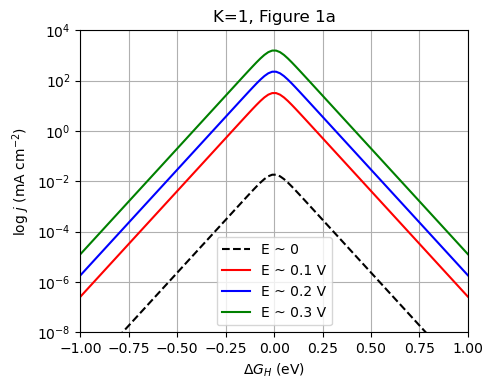

In [7]:
deltaGplot = np.linspace(-1,1,100)

K_Fig1a=1
plt.figure(figsize=(5,4), dpi=100)
plt.semilogy(deltaGplot,jEqn19(1e-4,deltaGplot,K_Fig1a)/(mA*cm**-2), 'black',linestyle='--', label='E ~ 0') 
plt.semilogy(deltaGplot,jEqn19(0.1,deltaGplot,K_Fig1a)/(mA*cm**-2) , 'red', label='E ~ 0.1 V')   
plt.semilogy(deltaGplot,jEqn19(0.2,deltaGplot,K_Fig1a)/(mA*cm**-2) , 'blue', label='E ~ 0.2 V')   
plt.semilogy(deltaGplot,jEqn19(0.3,deltaGplot,K_Fig1a)/(mA*cm**-2) , 'green', label='E ~ 0.3 V')   
plt.legend(loc='best')

plt.title('K=1, Figure 1a')

plt.xlabel("$\Delta G_H$ (eV)")
plt.ylabel("log $j$ (mA cm$^{-2}$)")

plt.xlim(-1.0,1.0)
plt.ylim(1e-8,1e4)


plt.grid()
plt.show()

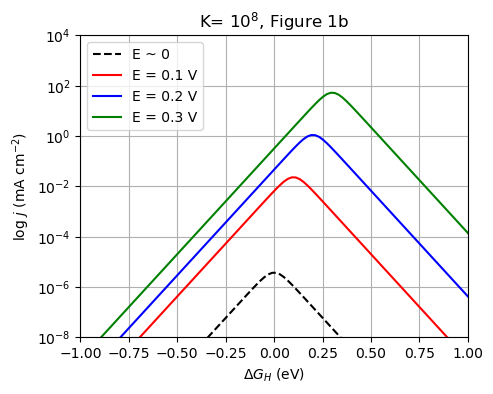

In [8]:
deltaGplot = np.linspace(-1,1,100)

K_Fig1b=1e8
plt.figure(figsize=(5,4), dpi=100)
plt.semilogy(deltaGplot,jEqn19(1e-4,deltaGplot,K_Fig1b)/(mA*cm**-2), 'black',linestyle='--', label='E ~ 0') 
plt.semilogy(deltaGplot,jEqn19(0.1,deltaGplot,K_Fig1b)/(mA*cm**-2) , 'red', label='E = 0.1 V')   
plt.semilogy(deltaGplot,jEqn19(0.2,deltaGplot,K_Fig1b)/(mA*cm**-2) , 'blue', label='E = 0.2 V')   
plt.semilogy(deltaGplot,jEqn19(0.3,deltaGplot,K_Fig1b)/(mA*cm**-2) , 'green', label='E = 0.3 V')   
plt.legend(loc='best')

plt.title('K= $10^8$, Figure 1b')

plt.xlabel("$\Delta G_H$ (eV)")
plt.ylabel("log $j$ (mA cm$^{-2}$)")

plt.xlim(-1.0,1.0)
plt.ylim(1e-8,1e4)

plt.grid()
plt.show()

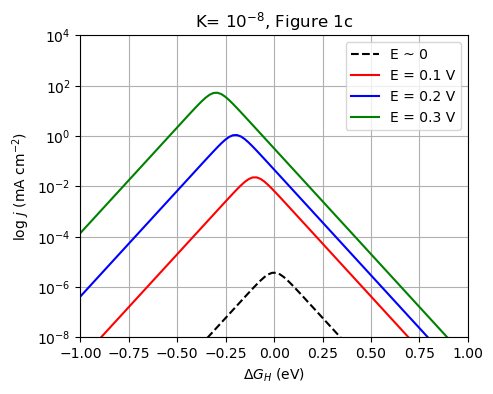

In [9]:
deltaGplot = np.linspace(-1,1,100)

K_Fig1c=1e-8
plt.figure(figsize=(5,4), dpi=100)
plt.semilogy(deltaGplot,jEqn19(1e-4,deltaGplot,K_Fig1c)/(mA*cm**-2), 'black',linestyle='--', label='E ~ 0') 
plt.semilogy(deltaGplot,jEqn19(0.1,deltaGplot,K_Fig1c)/(mA*cm**-2) , 'red', label='E = 0.1 V')   
plt.semilogy(deltaGplot,jEqn19(0.2,deltaGplot,K_Fig1c)/(mA*cm**-2) , 'blue', label='E = 0.2 V')   
plt.semilogy(deltaGplot,jEqn19(0.3,deltaGplot,K_Fig1c)/(mA*cm**-2) , 'green', label='E = 0.3 V')   
plt.legend(loc='best')

plt.title('K= $10^{-8}$, Figure 1c')

plt.xlabel("$\Delta G_H$ (eV)")
plt.ylabel("log $j$ (mA cm$^{-2}$)")

plt.xlim(-1.0,1.0)
plt.ylim(1e-8,1e4)

plt.grid()
plt.show()

## Figure 2
Optimal binding energy as a function of overponential for different kinetic ratios

In [10]:
def E1max_Eqn23(E, K):
    prefactor = (R*T)/(2*alpha*F)   # Should yield eV
    numerator = K*np.exp(2*f*E) +1
    demoninator = np.exp(2*f*E) + K  
    return prefactor*np.log(numerator/demoninator)

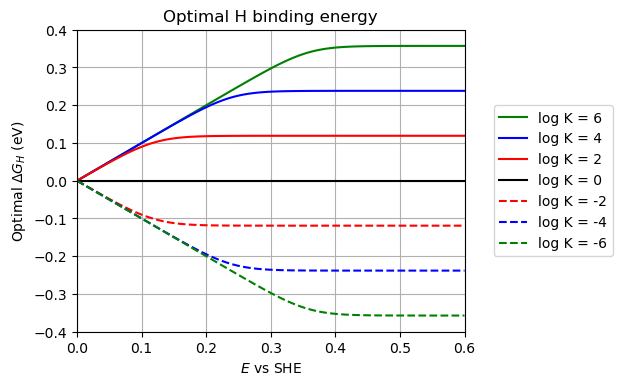

In [11]:
Eplot = np.linspace(0,0.6,100)

K_Fig1c=1e-8
plt.figure(figsize=(5,4), dpi=100)
plt.plot(Eplot, E1max_Eqn23(Eplot,1e6), 'green', label='log K = 6') 
plt.plot(Eplot, E1max_Eqn23(Eplot,1e4), 'blue', label='log K = 4') 
plt.plot(Eplot, E1max_Eqn23(Eplot,1e2), 'red', label='log K = 2') 

plt.plot(Eplot, E1max_Eqn23(Eplot,1), 'black', label='log K = 0') 

plt.plot(Eplot, E1max_Eqn23(Eplot,1e-2), 'red',linestyle='--', label='log K = -2')
plt.plot(Eplot, E1max_Eqn23(Eplot,1e-4), 'blue',linestyle='--', label='log K = -4') 
plt.plot(Eplot, E1max_Eqn23(Eplot,1e-6), 'green',linestyle='--', label='log K = -6') 
  
plt.legend(bbox_to_anchor=(1.4,0.5), loc="center right")

plt.title('Optimal H binding energy')

plt.xlabel("$E$ vs SHE")
plt.ylabel("Optimal $\Delta G_H$ (eV)")

plt.xlim(0,0.6)
plt.ylim(-0.4,0.4)

plt.grid()
plt.show()

Note that for positive values of $\rm{log}(K)$ a positive binding energy is optimal. This speeds up forward rate of reaction (2).

Conversely, for negative values of $\rm{log}(K)$ a negative binding energy is optimal. I believe that this means one needs to speed up the forward rate of reaction (1) by making $\ce{H_{ads}}$ more stable.

## Figure 3

At a given applied potential, current as a function of $\Delta G_H$ and the kinetic ratio *K*

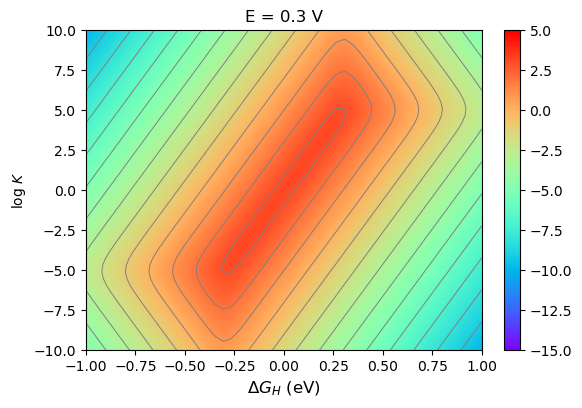

In [12]:
# change this to get panels (a)-(d)
E_plot = 0.3      # (a) 1e-4, (b) 0.l, (c) 0.3, (d) 0.5

# constructing the mesh, note used of meshgrid
deltaGcontour=np.linspace(-1,1,50)
logKcontour = np.linspace(-10,10,50)
xmesh,ymesh = np.meshgrid(deltaGcontour, logKcontour)

# Calculating the data for the plot
Zcontour = np.log10((jEqn19(E_plot, xmesh, 10**ymesh))/(mA*cm**-2))

fig = plt.figure(figsize=(5.5,4), dpi=100)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

# Drawing the contour lines
cp = ax.contour(xmesh, ymesh, Zcontour, 
                vmin=-15, vmax=5,
                levels=15,
                colors='gray',        # otherwise colors will change
                linestyles = 'solid', # otherwise negative values are dashed
                linewidths = 0.7)

# Drawing the colore
pmap = ax.pcolormesh(xmesh, ymesh, Zcontour, 
                     shading='gouraud',
                     vmin=-15, vmax=5,
                     cmap='rainbow') # this makes the nice colors 
#plt.colorbar(cp)
plt.colorbar(pmap, ax=ax, fraction=0.05) # Finally, add color bar.

ax.set_title('E = {} V'.format(E_plot))
ax.set_xlabel('$\Delta G_H$ (eV)', fontsize=12)
ax.set_ylabel('log $K$')
plt.show()

## Steady state *H and * coverages

Do these as a function of *E* for different combinations of $E_1$ and kinetic ratio *K*.  
When $E_1$ = 0, \*H is 0.5 always, it is a perfect catalyst. 

For other combination of values, half coverage crossing point is always at *E* = 0

In [13]:
# Make functions with default values
#  We can overwrite them by passing individual values e.g. E1 = 0.5
#  Or by passing a list of parameters
#  ** is used to expand the list

def k1(E, E1=0, k1zero=1*sec**-1, k2zero=1*sec**-1):   # Trying some keyword arguments
    return k1zero*np.exp(f*(E-E1))

def kminus1(E, E1=0, k1zero=1*sec**-1, k2zero=1*sec**-1):   # Trying some keyword arguments
    return k1zero*np.exp(-f*(E-E1))

def k2(E, E1=0, k1zero=1*sec**-1, k2zero=1*sec**-1):   # Trying some keyword arguments
    return k2zero*np.exp(f*(E+E1))

def kminus2(E, E1=0, k1zero=1*sec**-1, k2zero=1*sec**-1):   # Trying some keyword arguments
    return k2zero*np.exp(-f*(E+E1))

# now, how to pass through? Perhaps this is not an issue
# But need to remember to set them. 
def Hstar_steady_state(E):
    top =  (k1(E,**params)+kminus2(E,**params))
    bottom = (k1(E,**params)+kminus1(E,**params)+k2(E,**params)+kminus2(E,**params))
    return(top/bottom)

def Star_steady_state(E):
    top =  (kminus1(E,**params)+k2(E,**params))
    bottom = (k1(E,**params)+kminus1(E,**params)+k2(E,**params)+kminus2(E,**params))
    return(top/bottom)
    
# Not sure so keep going

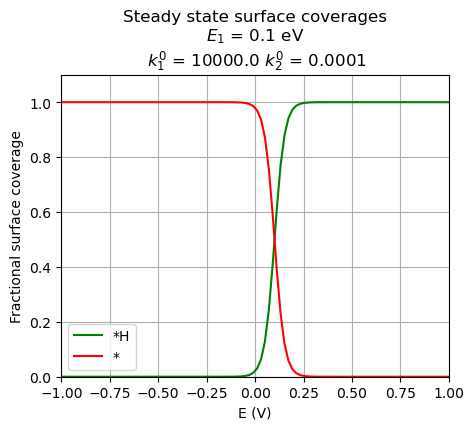

In [14]:
# Method to change parameter
#  These are python dictionaries
params0 = {'E1': 1e-4,'k1zero' : 1,'k2zero':1}    # Figure 1a, optimal is 
params1 = {'E1': 0.1,'k1zero' : 1.1,'k2zero':1}
params2 = {'E1': 0.1,'k1zero' : 1e4,'k2zero':1e-4}
params3 = {'E1': 0.1,'k1zero' : 1e-4,'k2zero':1e4}

# Choose parameters for this cell
params = params2

Eplot = np.linspace(-1,1,100)

plt.figure(figsize=(5,4), dpi=100)

plt.plot(Eplot, Hstar_steady_state(Eplot), 
                'g', label = "*H") 
plt.plot(Eplot, Star_steady_state(Eplot), 
                'r', label = "*") 

plt.legend(loc='best')

plt.title('Steady state surface coverages\n$E_1$ = {} eV\n $k_1^0$ = {} $k_2^0$ = {} '.format(params.get('E1'),params.get('k1zero'),params.get('k2zero')))   #figure out later how to expand params in title
plt.xlabel("E (V)")
plt.ylabel("Fractional surface coverage")

plt.xlim(-1.0,1.0)
plt.ylim(0,1.1)

plt.grid()
plt.show()

Observations
* If *K* = 1, coverages do not change with potential
* If *K* >> 1, then coverage will change from $*$ to*H at E = E1
* If *K* << 1, then coverage will change from *H to $*$ at E = -E1

## Simulated CV scans

Assuming unit activities for $\ce{H2}$ and $\ce{H+}$, the two ODEs to integrate in time are:

$$ \frac{d [\ce{H_{ads}}]}{dt} =  k_{1}(E)[\ce{$*$}] + k_{-2}(E)[\ce{$*$}] -  k_{-1}(E)[\ce{H_{ads}}] - k_{2}(E))[\ce{H_{ads}}] $$

$$ \frac{d [\ce{$*$}]}{dt} =  k_{-1}(E)[\ce{H_{ads}}] + k_{2}(E)[\ce{H_{ads}}] - k_{1}(E)[\ce{$*$}] - k_{-2}(E)[\ce{$*$}] $$

where the rates constants are time dependent functions of $E(t)$ as defined by the CV scan parameters. 

In [15]:
# Function to construct a single CV scan
Estart = -0.4 *volt
Efinish = 0.4 *volt
sweep_rate = 50.0 *mV*sec**-1
cycle_time = 2.0 * (Efinish-Estart)/sweep_rate 

def E_CV(t):
    if t<0:
        E = Estart
    elif (t>0 and t < cycle_time/2.0):
        E = Estart + t*sweep_rate
    elif(t>0  and t > cycle_time/2. and t < cycle_time ):
        E = Efinish - (t - cycle_time/2.0) *sweep_rate
    else:
        E = Estart
    return E        

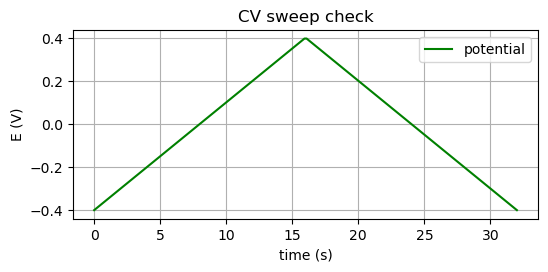

In [16]:
# Checking the CV sweep

t_plot = np.linspace(0,cycle_time,200)
# need to do this because cannot send array to boolean arguments
temp = np.empty(t_plot.size)
for i in range(t_plot.size):
    temp[i] = E_CV(t_plot[i])


plt.figure(figsize=(6,2.5), dpi=100)
plt.plot(t_plot, temp, 'g', label = "potential") 

plt.legend(loc='best')
plt.title('CV sweep check')
plt.xlabel("time (s)")
plt.ylabel("E (V)")
plt.grid()
plt.show()

In [20]:
# setting up the ODE solver for the two equations

def CV_scan_ODEs(t, z):
    Hstar= z[0]
    star = z[1]
    
    dHstar_dt = k1(E_CV(t),**params)*star + kminus2(E_CV(t),**params)*star \
    - kminus1(E_CV(t),**params)*Hstar - k2(E_CV(t),**params)*Hstar
    
    dstar_dt =  kminus1(E_CV(t),**params)*Hstar + k2(E_CV(t),**params)*Hstar \
    - k1(E_CV(t),**params)*star - kminus2(E_CV(t),**params)*star
    dzdt = [dHstar_dt,dstar_dt]
    return dzdt

CV scan initiated:
H coverage  = 3.989e-09
empty sites = 1.000e+00


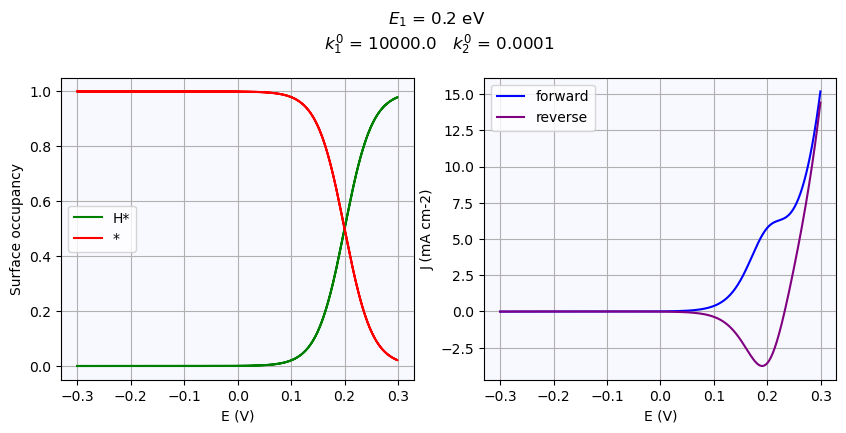

In [73]:
# Choose parameters for the simulations.  More cases can be added
params1a_opt =    {'E1': 0.00,'k1zero' : 1,'k2zero':1}
params1a_nonopt = {'E1': 0.35,'k1zero' : 1,'k2zero':1}


params1b_opt =    {'E1': 0.35,'k1zero' : 1e4,'k2zero':1e-4}
params1b_nonopt = {'E1': 0.2,'k1zero' : 1e4,'k2zero':1e-4}

params1c_opt =    {'E1': -0.35,'k1zero' : 1e-4,'k2zero':1e4}
params1c_nonopt = {'E1': -0.1,'k1zero' : 1e-4,'k2zero':1e4}

# Set the parameter set to be used in current simulation
params=params1b_nonopt          # See cells above for more parameter sets

# Sweep parameters
Estart = -0.3 *volt              # E = 0.3 was largest driving force in Figure 1
Efinish = 0.3 *volt              # Larger driving forces lead to huge currents. 
sweep_rate = 50.0*mV*sec**-1
cycle_time = 2.0 * (Efinish-Estart)/sweep_rate 

# Intial conditions 
Hstar_init = Hstar_steady_state(Estart)
Star_init = Star_steady_state(Estart)

# Boundary conditions for odeint
z0 = [Hstar_init, Star_init]   

print('CV scan initiated:')
print(f'H coverage  = {Hstar_init:.3e}')
print(f'empty sites = {Star_init:.3e}')

# time points for ODE integration
t_CV = np.linspace(0, cycle_time, 1000)

# solve ODE, needed to decrease the tolerance to get a nice solution
sol = solve_ivp(CV_scan_ODEs, 
              [0, cycle_time], 
              z0,
              t_eval=t_CV,
              method='Radau', atol=1e-12, rtol=1e-12)

θ_H = sol.y[0]
θ_star = sol.y[1]

# Compute the E values for the CV plot 
E_CV_plot = np.empty(t_CV.size)
for i in range(t_CV.size):
    E_CV_plot[i] = E_CV(t_CV[i])
       
# Compute Current densities for the plot
J_CV_plot = np.empty(E_CV_plot.size)
for i in range(E_CV_plot.size):
    J_CV_plot[i] = (nTransfer*q*Nsites)*(k1(E_CV_plot[i], **params)* θ_star[i] - \
                                     kminus1(E_CV_plot[i], **params)*θ_H[i])
# Displayt the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=100)

fig.suptitle('$E_1$ = {} eV\n $k_1^0$ = \
{}   $k_2^0$ = {}'.format(params.get('E1'),
                        params.get('k1zero'),
                        params.get('k2zero')), y =1.05)  
# LH figure
ax1.plot(E_CV_plot, θ_H, 'g', label = "H*") 
ax1.plot(E_CV_plot, θ_star, 'r', label = "*") 
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("E (V)")
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(-0.05,1.05)
ax1.set_facecolor('ghostwhite')
# RH figure
ax2.plot(np.split(E_CV_plot,2)[0], np.split(J_CV_plot,2)[0]/(mA*cm**-2),'blue', label='forward')
ax2.plot(np.split(E_CV_plot,2)[1], np.split(J_CV_plot,2)[1]/(mA*cm**-2),'purple', label='reverse')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("E (V)")
ax2.set_ylabel("J (mA cm-2)")
ax2.set_facecolor('ghostwhite')

plt.show()

Observations.  
CV scans do support the analysis in paper.  
Note if that one scans too far, currents get very large as reactants are at unit activity and there are no mass transfer limits. Also note that tolerance for the solver can to be adjusted as the current are determined by the products of very large and very small numbers.  